Read CSV with encoding: latin-1


C:\Users\geoec\AppData\Local\Temp\ipykernel_28908\3709055659.py:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  mat = data.pivot_table(index="Phase", columns="Model", values="Value").reindex(index=phases, columns=model_order)
C:\Users\geoec\AppData\Local\Temp\ipykernel_28908\3709055659.py:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  mat = data.pivot_table(index="Phase", columns="Model", values="Value").reindex(index=phases, columns=model_order)
C:\Users\geoec\AppData\Local\Temp\ipykernel_28908\3709055659.py:86: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=Fa

Saved: C:\Users\geoec\OneDrive\Desktop\Figure\model_performance_3x2.png


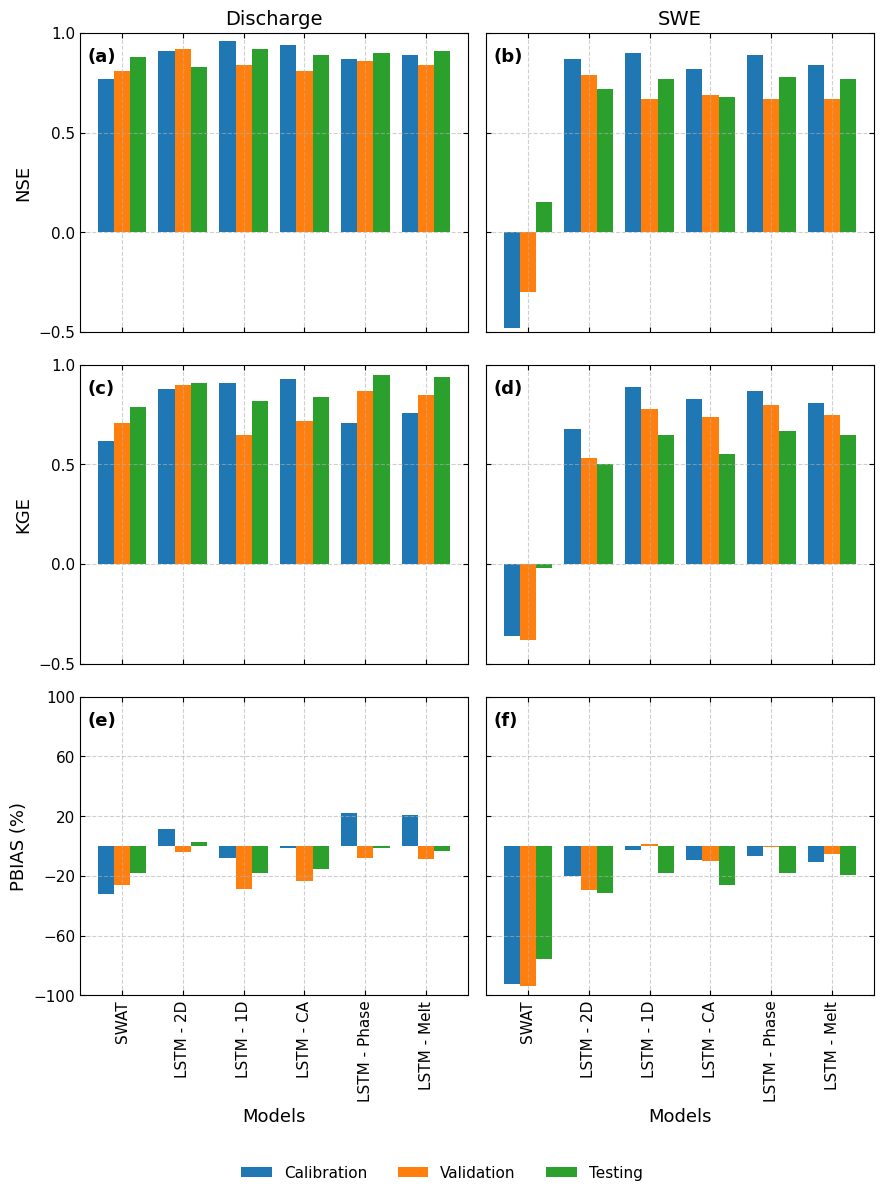

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


plt.rcParams.update({
    "font.size": 12,        
    "axes.titlesize": 14,   
    "axes.labelsize": 13,  
    "xtick.labelsize": 11,  
    "ytick.labelsize": 11,  
    "legend.fontsize": 11,  
    "legend.title_fontsize": 12,
    "xtick.direction": "in",  
    "ytick.direction": "in",
    "xtick.top": True,       
    "ytick.right": True      
})


file_path = Path(r"C:\Users\geoec\OneDrive\Desktop\metrics.csv")
out_dir = Path(r"C:\Users\geoec\OneDrive\Desktop\Figure")
out_dir.mkdir(parents=True, exist_ok=True)
out_png = out_dir / "model_performance_3x2.png"


encodings_to_try = ["utf-8-sig", "latin-1", "utf-16"]
for enc in encodings_to_try:
    try:
        df = pd.read_csv(file_path, encoding=enc)
        print(f"Read CSV with encoding: {enc}")
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

phase_row = df.iloc[0]

var_blocks = [
    ("Discharge", ["Discharge", "Unnamed: 3", "Unnamed: 4"]),
    ("Snow Water Equivalent", ["Snow Water Equivalent", "Unnamed: 6", "Unnamed: 7"]),
]

records = []
for i in range(1, len(df)):  
    row = df.iloc[i]
    model = str(row["Model"]).strip()
    metric = str(row["Metrics"]).strip()
    if model == "nan" or metric == "nan":
        continue
    for var, cols in var_blocks:
        for c in cols:
            phase = str(phase_row[c]).strip() 
            val = row[c]
            if isinstance(val, str):
                val = val.replace("%", "").strip()
            try:
                val = float(val)
            except Exception:
                val = np.nan
            records.append({
                "Model": model,
                "Metric": metric,
                "Variable": "SWE" if var.lower().startswith("snow") else var,
                "Phase": phase,
                "Value": val
            })

long_df = pd.DataFrame(records)

metrics = ["NSE", "KGE", "PBIAS"]
variables = ["Discharge", "SWE"]
phases = ["Calibration", "Validation", "Testing"]
model_order = long_df["Model"].drop_duplicates().tolist()

def grouped_bar_subplot(ax, data, ylabel, show_ylabel=True, show_xticks=False):
    data = data.copy()
    data["Model"] = pd.Categorical(data["Model"], categories=model_order, ordered=True)
    data["Phase"] = pd.Categorical(data["Phase"], categories=phases, ordered=True)
    data = data.sort_values(["Model", "Phase"])
    mat = data.pivot_table(index="Phase", columns="Model", values="Value").reindex(index=phases, columns=model_order)

    x = np.arange(mat.shape[1])
    n_ph = mat.shape[0]
    width = 0.8 / n_ph
    for i, ph in enumerate(mat.index):
        ax.bar(x + i*width - (n_ph-1)*width/2, mat.loc[ph].values, width, label=ph)

    ax.set_xticks(x)
    if show_xticks:
        ax.set_xticklabels(mat.columns, rotation=90)
    else:
        ax.set_xticklabels([])

    if show_ylabel:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.grid(axis="both", linestyle="--", alpha=0.6)

fig, axes = plt.subplots(3, 2, figsize=(9, 12))

panel_tags = [["(a)", "(b)"], ["(c)", "(d)"], ["(e)", "(f)"]]
titles_row1 = ["Discharge", "SWE"]  

for r, metric in enumerate(metrics):
    for c, var in enumerate(variables):
        ax = axes[r, c]
        sub = long_df[(long_df["Metric"] == metric) & (long_df["Variable"] == var)]
        ylabel = metric if metric != "PBIAS" else "PBIAS (%)"

        grouped_bar_subplot(
            ax, sub, ylabel,
            show_ylabel=(c == 0),    
            show_xticks=(r == 2)     
        )

        if r == 0:
            ax.set_title(titles_row1[c])
        else:
            ax.set_title("")

        ax.text(0.02, 0.95, panel_tags[r][c], transform=ax.transAxes,
                ha="left", va="top", fontweight="bold", fontsize=13)

        if r == 2:
            ax.set_xlabel("Models")

for ax in [axes[0,0], axes[0,1]]:  
    ax.set_ylim(-0.5, 1.0)
    ax.set_yticks(np.arange(-0.5, 1.1, 0.5))

for ax in [axes[1,0], axes[1,1]]:  
    ax.set_ylim(-0.5, 1.0)
    ax.set_yticks(np.arange(-0.5, 1.1, 0.5))

for ax in [axes[2,0], axes[2,1]]:  
    ax.set_ylim(-100, 100)
    ax.set_yticks(np.arange(-100.0, 100.1, 40.0))

handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="lower center", ncol=len(phases), frameon=False)

plt.tight_layout(rect=[0, 0.04, 1, 1])

fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Saved: {out_png}")

plt.show()
